## 21D008 Probabilistic Inference - Project: Elliptical Slice Sampling in Classification

In [1]:
import sys, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy
from scipy.stats import multivariate_normal
from numpy.random import multivariate_normal as mn
from gpc import *
from EllipticalSliceSampler import EllipticalSampler
from utils import (
    plot_contour,
    plot_ESS,
    plot_live,
    gaussian_kernel
)
np.random.seed(32)
cmap=colors.ListedColormap(["tab:cyan", "tab:green", "tab:gray"])

### Toy examples
This section presents mock examples to highlight some of the behavior our elliptical slice sampler exhibits, as well as to show the predictive performance of the sampler under baseline kernels and hyperparameters for both 1D and 2D Gaussian examples.  

#### Toy Example: Elliptical Slice Sampler

We define a vector $\mathbf{f} \sim \mathcal{N}(\mu^{prior},\Sigma^{prior})$ and a likelihood $L(\mathbf{f})=p($ data $\mid \mathbf{f})$, which for convenience we choose to follow another Gaussian distribution with the same prior parameters. While overly simplistic, we are able to easily compute the analytic posterior parameters of our latent $\mathbf{f}$. The arbitrary set of prior parameters writes

$$
\mu^{prior} = \left[\begin{array}{c}
1  \\
2
\end{array}\right] \quad \quad \quad \quad \quad \quad \quad 
\Sigma^{prior} \approx 
\left[\begin{array}{cc}
2.58 & -0.67  \\
-0.67 & 1.09
\end{array}\right]
$$

In order to test the performance of our elliptical slice sampler, we will present here some of the steps internal to the function, and we will visualize its performance. 

In [2]:
prior_µ = np.array([1,2])
prior_Σ = np.array(
    [[ 2.58319407, -0.67001488],
    [-0.67001488,  1.09846023]]
)

Unlike in our main classification application, the likelihood function here corresponds to that of a Gaussian:

In [3]:
loglik = lambda f: np.log(multivariate_normal.pdf(f, mean=prior_µ, cov=prior_Σ))

The first draw of $\mathbf{f}$ in the elliptical slice sampler is a particular draw from a multivariate normal with our defined priors, while subsequent iterations will use the accepted candidates as incumbent values for $\mathbf{f}$. Similarly, we draw a value for $\nu$ from a multivariate normal with parameters set by our priors. 

In [4]:
f_incumbent = (mn(prior_µ - prior_µ, prior_Σ, size=1)).squeeze()
nu = mn(prior_µ - prior_µ, prior_Σ, size=1)

The slice sampling will then select a location (a candidate $\mathbf{f}$) on a randomly generated ellipse. To determine our candidate location, we define an angle $\theta$ drawn as $\theta \sim \mathcal{U}[0,2\pi]$. We further bound future choices of $\theta$ to fall within a bracket $[\theta - 2\pi, \theta]$, from which we make uniform draws if the first candidate $\mathbf{f}$ is not selected.

In [5]:
Θ = np.random.uniform(0 + sys.float_info.min, 2*np.pi)
Θ_min, Θ_max = Θ - 2*np.pi, Θ

In order to decide whether to accept the candidate, we define $\log y$, which comprises the likelihood of the incumbent $\mathbf{f}$ and some negative parameter drawn from a uniform. We will compare the likelihood of the candidate to $\log y$, and we will accept if it is larger.

In [6]:
log_y = loglik(f_incumbent) + np.log(np.random.uniform(0,1))

Having defined the initial parameters, we can now repeatedly consider different candidates until accepting a new $\mathbf{f}$. The algorithm is adaptive: it will shrink the regions of the ellipse eligible for evaluation following failure to reject a candidate, so that in the worst case scenario we select the incumbent $\mathbf{f}$ itself. Note that the shrinking of the eligible $\theta$ will depend on whether the previous value was positive or negative.

We will run a first simulation of the ESS, drawing the eligible area of the ellipse (black if eligible, gray if not) as well as those regions that, if evaluated, would lead to acceptance of a new $\mathbf{f}$ (green). We consider $f_t$ to be the incumbent value for $\mathbf{f}$, and $f_{t+1}$ to be the candidate. Recall this candidate is drawn as

$$
\mathbf{f}_{t+1}=\boldsymbol{\nu}_t \sin \theta_{t+1}+\mathbf{f}_t \cos \theta_{t+1}
$$

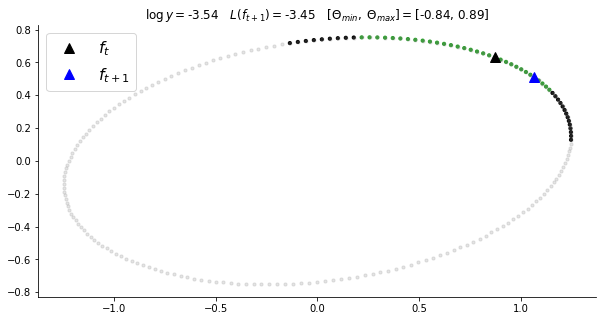

In [7]:
first, i = True, 0
while True:
    i+=1
    # Define candidate
    f_candidate = (f_incumbent * np.cos(Θ) + nu * np.sin(Θ)).squeeze()

    plot_ESS(log_y, f_incumbent, f_candidate, Θ_min, Θ_max, nu, loglik, first=first, save=False, i=i, figsize=(10,5))
    time.sleep(1)
    if loglik(f_candidate) > log_y:
        f_incumbent = f_candidate
        break
    elif Θ < 0:
        Θ_min = Θ
    elif Θ > 0:
        Θ_max = Θ
    first=False
    Θ = np.random.uniform(Θ_min, Θ_max)

### Drawing posteriors

The advantage of using a Gaussian likelihood is that we are able to test whether we approximate the analytical solution of the posterior distribution, thus providing reassuring evidence that our slice sampler works as expected. Let's instantiate the class that we define in a standalone script <code>EllipticalSliceSampler.py</code>, and repeat the process above $10000$ times. We will burn out the first $1000$ observations.

In [8]:
ess = EllipticalSampler(prior_μ=prior_μ, prior_Σ=prior_Σ, ll=loglik)
draws = ess.sample(num_samples=10000, num_burnin=1000, verbose=2)

100%|██████████| 10000/10000 [00:09<00:00, 1098.35it/s]


Given our multivariate normal with normal-distributed latent parameter $\mathbf{f}$, we can define the analytical solution to the posterior $\Sigma$ as

$$
\Sigma^{post} = \Sigma^{prior} \cdot \left(\Sigma^{prior} + \Sigma^{\mathbf{f}}\right)^{-1} \cdot \Sigma^{\mathbf{f}}
$$

In [9]:
post_Σ = prior_Σ @ scipy.linalg.inv(2*prior_Σ) @ prior_Σ

# Posterior using analytical solution
print(post_Σ)

[[ 1.29159703 -0.33500744]
 [-0.33500744  0.54923011]]


We can now create the covariance matrix of our posterior samples, and check whether it is approximately similar to the analytical posterior covariance matrix.

In [10]:
np.cov(draws.T).tolist()

[[1.3243419046719287, -0.3299077468962936],
 [-0.3299077468962936, 0.553353573916692]]

We can further visualize these results, and test the convergence of the posterior $\Sigma$ to the analytical solution.

In [11]:
# Demean posterior observations
plot_draws = np.subtract(draws, np.mean(draws.T, axis=1))

# Draw topography for the analytical standard deviation
basespace = np.linspace(0,2*np.pi, 200)
points = np.array([np.cos(basespace),np.sin(basespace)])
sd_ellipse = np.linalg.cholesky(np.cov(draws.T)) @ points
sd2_ellipse = 2 * np.linalg.cholesky(np.cov(draws.T)) @ points

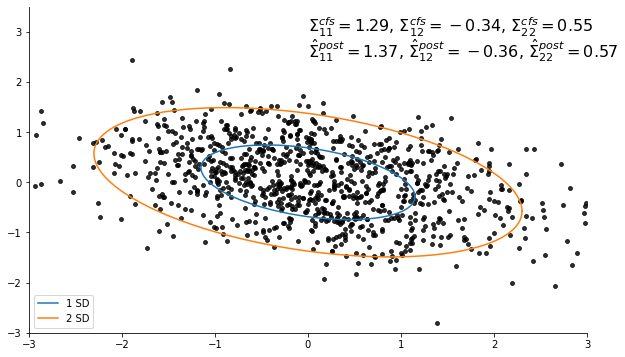

In [12]:
for i in range(20):
    data = plot_draws[:(i+1)*50]
    plot_live(data, prior_Σ, sd_ellipse, sd2_ellipse)
    time.sleep(0.5)

These results are reassuring, and suggest we are indeed approximating the theoretical posterior distribution of $\mathbf{f}$ using our hand-coded Elliptical Slice Sampling.

### Toy Example: GPC

In an additional mock application, we consider the binary classification of nearly-linearly separable observations defined in a two dimensional space. We aim to show that our Gaussian Process classifier is able to both return good point estimates on the out-of-sample predictions as well as capture the relative uncertainty embedded in the data. 

Let's define our somewhat arbitrary data.

In [13]:
X1 = np.random.standard_normal(size=100)
X2 = np.random.normal(0,3,size=100)
X = np.dstack((X1,X2)).squeeze()
Y = np.where(0.5*X1 + 0.3*X2 + np.random.normal(0,0.2,100) > 0, 1, 0)

And let us also plot it.

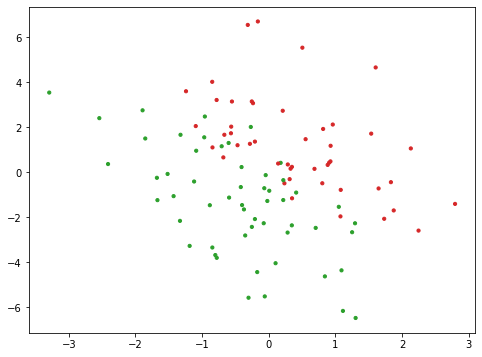

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.scatter(x=X[:,0], y=X[:,1], s=10, c=np.where(Y>0, "tab:red", "tab:green"))

We will split our dataset in 80 training observations and a held-out sample with 20 data points. 

In [15]:
train_X, train_Y = X[:80,:], Y[:80]
test_X, test_Y = X[80:,:], Y[80:]

We create an instance of our Gaussian Process Classifier, and define baseline $\sigma^2$ and $l$ hyperparameters of a Gaussian kernel as $[1,1]$. We will first predict using these values, and will then test whether we can improve our accuracy and prediction certainty by fine-tuning the kernel hyperparameters.

In [16]:
gpc = GPC(kernel=gaussian_kernel, hyperparameters=[1,1])
gpc.X, gpc.Y = train_X, train_Y

We use the <code>predict</code> method of the Gaussian Process Classifier class to draw predictions on the out-of-sample observations.

In [17]:
y_pred, _ = gpc.predict(test_X)
prob_pred = GPC._sigmoid(y_pred)

Let's plot our results. We also generate a contour plot to capture the topography of the uncertainty embedded in the data and captured by the model.

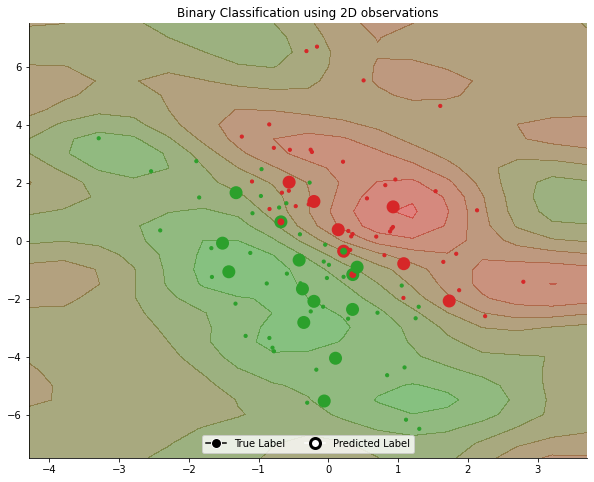

In [18]:
plot_contour(train_X, train_Y, test_X, test_Y, prob_pred, gpc, contour=True)

We can now optimize the hyperparameters of the kernel function using our in-sample observations, which ought to improve the performance of the model, as already showcased in the 1D example.

In [19]:
gpc.fit(train_X, train_Y, verbose=0, tol = 1e-1, eps = 1)

Fitted with final hyperparameters: [1.89600084 1.44405235] and neg log likelihood 25.154687718267418


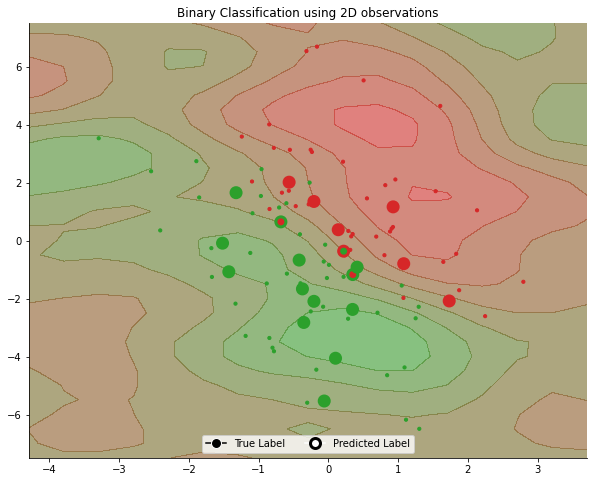

In [20]:
y_pred_fit, _ = gpc.predict(test_X)
prob_pred_fit = GPC._sigmoid(y_pred)

plot_contour(train_X, train_Y, test_X, test_Y, prob_pred_fit, gpc, contour=True)

While the previous results were already promising, classifying with optimized kernel hyperparameters yields minor improvements in this very basic example. 

In [21]:
from sklearn.metrics import roc_auc_score

print("Unfitted Model - ROC AUC Score = ", roc_auc_score(test_Y, GPC._sigmoid(y_pred)))
print("Fitted Model - ROC AUC Score = ", roc_auc_score(test_Y, GPC._sigmoid(y_pred_fit)))

Unfitted Model - ROC AUC Score =  0.90625
Fitted Model - ROC AUC Score =  0.9375
